# Measuring Errors and Fitting Models

* Topic: Supervised machine learning
* Unit: ADS1002
* Level: Beginner
* Authors: Simon Bowly, Kaustav Das
* Version: 3.2.1

Required files (download these from the Gitlab site [here](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Supervised-Methods) into the same directory as the notebook on your computer):

* [who-health-data.csv](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Supervised-Methods/who-health-data.csv)
* [wisconsin-cancer-data.csv](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Supervised-Methods/kaggle-wisconsin-cancer.csv)

The objective of this notebook is to help you understand some of the terminology, computations and methods behind supervised training of predictive machine learning models. Some of this content will be familiar from the last 3 weeks of ADS1001 where you looked at regression and classification models. Here we take a step back to better understand the concepts behind the modelling methods we will focus on this semester. We'll also review these concepts throughout the semester as we explore further machine learning algorithm types.

In [1]:
# Remember these? Our usual package imports for handling data.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specialised functions for calculating prediction error rates.
from sklearn.metrics import precision_score

import warnings
warnings.filterwarnings("ignore")

## Supervised Learning

Simply put, **supervised learning** is a process of **training** a machine learning **model** based on a sampled dataset with known inputs and outputs. Two key types of supervised learning models are **regression** and **classification** models. We'll cover both this semester; and you've already seen some in semester one (linear regression and kNN classification).

Let's first look at some examples of datasets used for regression and classification tasks.

### WHO Life Expectancy Tables

The WHO tracks various metrics for countries as they relate to life expectancy, and mortality rates of different populations. This dataset was originally found here https://www.kaggle.com/kumarajarshi/life-expectancy-who/. Here we'll consider just one input (education level), and one output (adult life expectancy). With this simple dataset we could build a model to predict average life expectancy based on education levels within a country. This is a regression task; the output variable is a continuous measure.

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
16,Albania,2015,Developing,77.8,74.0,0,4.60,364.975229,99.0,0,...,99.0,6.00,99.0,0.1,3954.227830,28873.0,1.2,1.3,0.762,14.2
32,Algeria,2015,Developing,75.6,19.0,21,NaN,0.000000,95.0,63,...,95.0,NaN,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4
48,Angola,2015,Developing,52.4,335.0,66,NaN,0.000000,64.0,118,...,7.0,NaN,64.0,1.9,3695.793748,2785935.0,8.3,8.2,0.531,11.4
64,Antigua and Barbuda,2015,Developing,76.4,13.0,0,NaN,0.000000,99.0,0,...,86.0,NaN,99.0,0.2,13566.954100,NaN,3.3,3.3,0.784,13.9


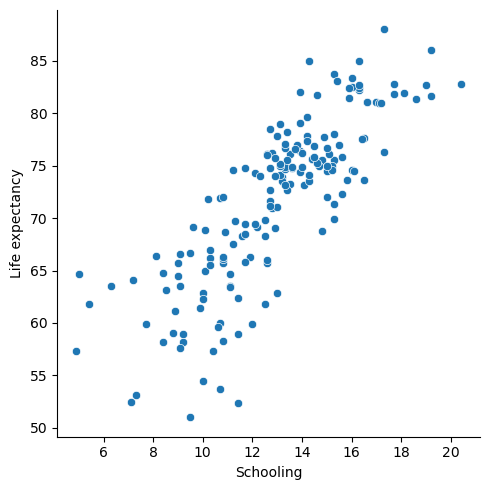

In [2]:
# Read the dataset into a dataframe.
# Method chaining
who_data_2015 = (
    pd.read_csv("who-health-data.csv")        # Read in the csv data.
    .rename(columns=lambda c: c.strip())      # Clean up column names. (removes white space)
    .query("Year == 2015")                    # Restrict the dataset to records from 2015.
)
# Plot our output vs input variable.
sns.relplot(
    data=who_data_2015,
    x="Schooling",
    y="Life expectancy",
);
who_data_2015.head(5)

### Wisconsin Breast Cancer Dataset

This dataset measures various properties of breast cancer biopsy results, along with a diagnosis of whether the tumour being tested is malignant or benign. The dataset was originally found here https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29.

There are many features here, but we'll consider just two: radius (size of the tissue sample) and texture (variation in colour across the surface). The diagnosis is a binary state (malignant/benign or postive/negative) so this is a classification dataset.

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,malignant,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,malignant,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,malignant,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,malignant,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,malignant,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


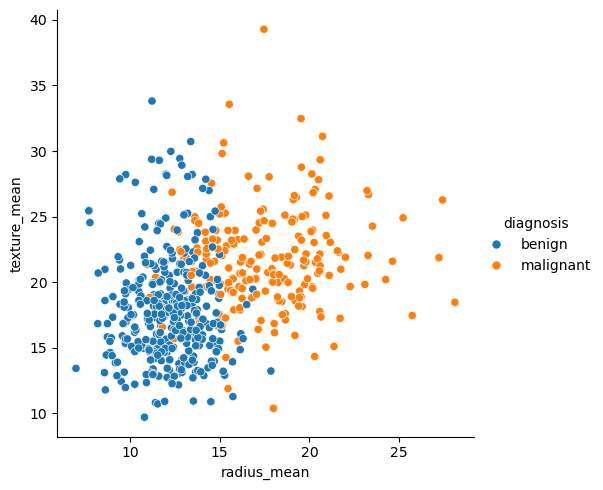

In [3]:
# Read dataset into a dataframe.
wisconsin_cancer_biopsies = (
    pd.read_csv("kaggle-wisconsin-cancer.csv")
    # This tidies up the naming of results (M -> malignant, B -> benign)
    .assign(diagnosis=lambda df: df['diagnosis']  
        .map({"M": "malignant", "B": "benign"})
        .astype('category')
    )
)
# Show the true diagnosis as a function of two variables.
sns.relplot(
    data=wisconsin_cancer_biopsies,
    x="radius_mean",
    y="texture_mean",
    hue="diagnosis",
);
wisconsin_cancer_biopsies.head(5)

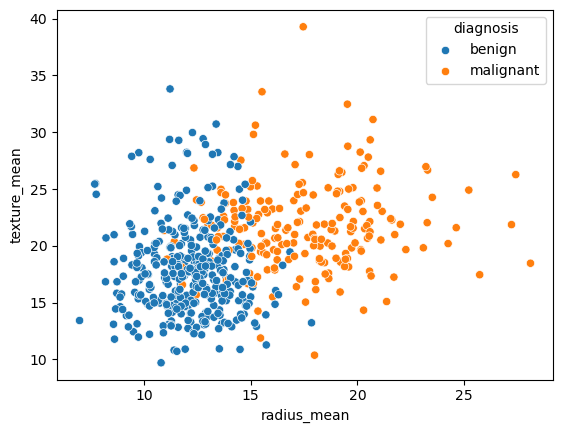

In [4]:
sns.scatterplot(
    data=wisconsin_cancer_biopsies,
    x="radius_mean",
    y="texture_mean",
    hue="diagnosis",
);

## Measures of Prediction Error

Supervised learning can be thought of as selecting among many possible models/parameters for the best one which fits to the data we have. Fundamental to this idea is having a way to measure error/coming up with a useful error metric. We want to select from among candidate models the one which yields the best predictions, in other words the one with the smallest measured error.

### Regression Error Metrics

Let's have a look at a simple set of predictions of life expectancy based on schooling in the WHO dataset. Here we've constructed a simple prediction where

$$
\text{Life expectancy} = 2.5 \times \text{Years of schooling} + 38 \text{ years.}
$$

,Schooling,Life expectancy,Predicted
0,10.1,65.0,63.25
16,14.2,77.8,73.50
32,14.4,75.6,74.00


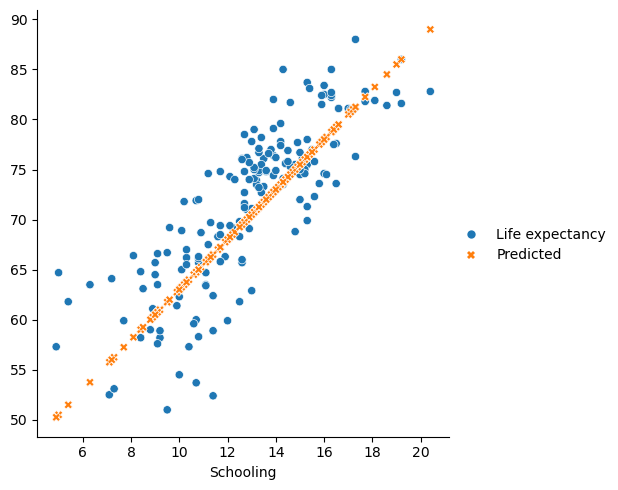

In [5]:
who_with_predictions = (
    who_data_2015[["Schooling", "Life expectancy"]]
    # Add a column with a computed prediction based on years of schooling.
    .assign(Predicted=lambda df: df["Schooling"] * 5/2 + 38)
    # Discard for the moment any row where we can't make a prediction
    # due to missing data.
    .dropna()
)
# Plot both the predicted and actual life expectancy results against years of schooling.
sns.relplot(data=who_with_predictions.set_index("Schooling"));
who_with_predictions.head(3)

For each sample point in the dataset, we compute prediction error by finding the difference between the value predicted by our simple model and the actual value. Below these errors are plotted as a histogram. We can see there is a roughly even spread of over- and under- predictions.

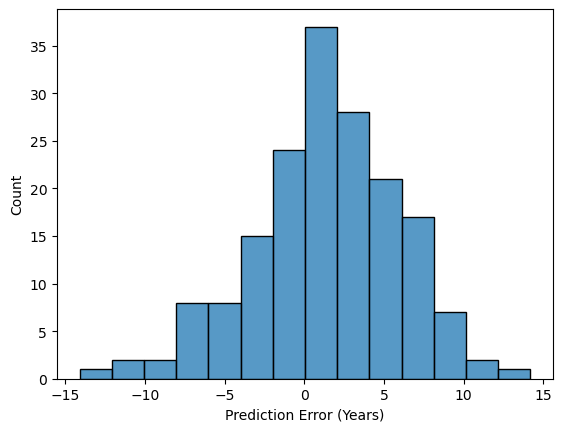

In [6]:
# Compute errors (difference between predicted and correct values).
errors = who_with_predictions['Life expectancy'] - who_with_predictions['Predicted']
# Plot the errors as a histogram.
ax = sns.histplot(errors)
ax.set_xlabel("Prediction Error (Years)");

From these errors, we can compute a single statistic representing the prediction error of this model. This is typically the Mean Absolute Error: average deviation of predictions from the true value. Mathematically:
$$
\text{MAE} = \frac{1}{N} \sum_{i \in N} \left| y^{\text{predicted}}_i - y^{\text{actual}}_i \right|
$$
where there are $N$ samples in the **training set**.

In [7]:
# Compute mean absolute error.
mae_score = errors.abs().mean()
print(f"Mean absolute error is {mae_score:.1f} years")

Mean absolute error is 3.9 years


### Classification Error Metrics

In classification tasks, we break down several statistics based on the number of correct and incorrect predictions, and the number of those which correspond to positive and negative labels. Let's look at a small subset of the biopsy data to understand these metrics.

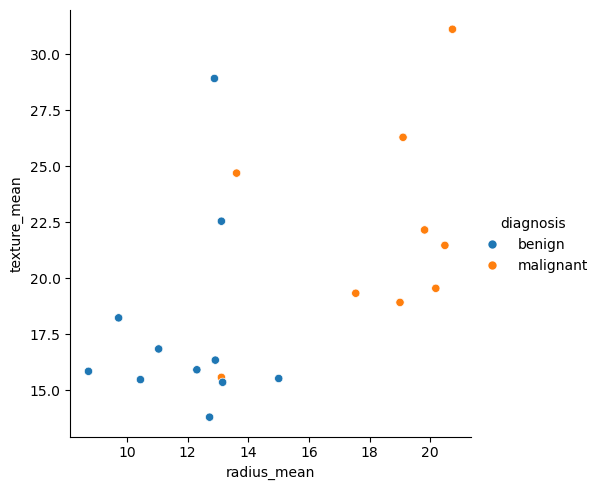

In [8]:
# Plot a small set of 20 sample points.
# .sample(20) selects 20 random points. Using the random_state parameter
# ensures that the selected points are always the same.
sns.relplot(
    data=wisconsin_cancer_biopsies.sample(20, random_state=162346),
    x="radius_mean",
    y="texture_mean",
    hue="diagnosis",
);

As an example, we develop a simple prediction here: all tests with a `radius_mean` value of less than 14 is considered benign, and anything larger is considered malignant. Below we plot a breakdown of the data by both its predicted label and its correct label.

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,predicted
195,875878,benign,12.91,16.33,82.53,516.4,0.07941,0.05366,0.03873,0.02377,...,22.00,90.81,600.6,0.1097,0.1506,0.17640,0.08235,0.3024,0.06949,benign
411,905520,benign,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,...,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881,benign
294,891716,benign,12.72,13.78,81.78,492.1,0.09667,0.08393,0.01288,0.01924,...,17.48,88.54,553.7,0.1298,0.1472,0.05233,0.06343,0.2369,0.06922,benign


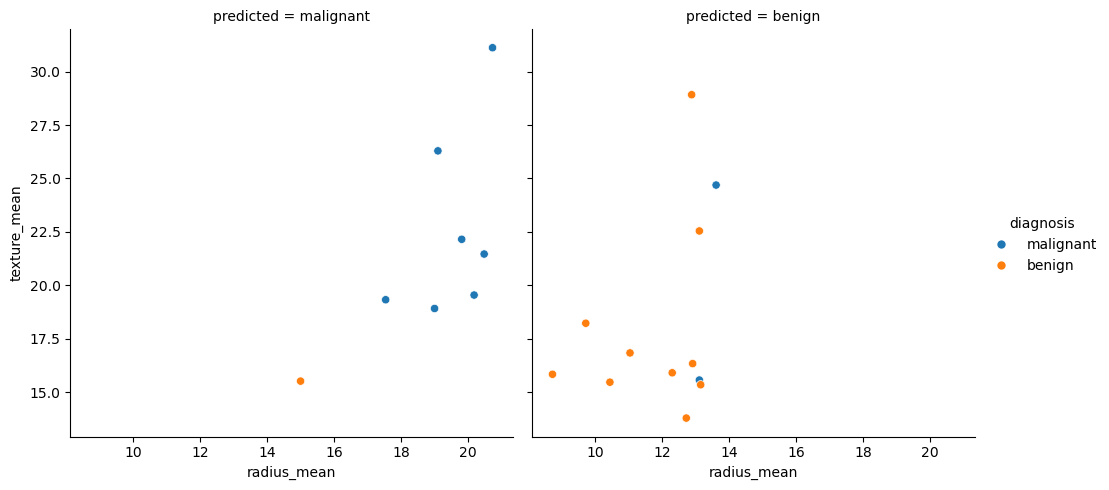

In [9]:
biopsies_with_predictions = (
    wisconsin_cancer_biopsies.sample(20, random_state=162346)
    # Apply a simple rule for prediction (based only on radius)
    # and add the prediction result as a column.
    .assign(predicted=lambda df: df['radius_mean'].lt(14)  # or lambda df: (df.radius_mean<14)
        .map({True: "benign", False: "malignant"})
    )
)
sns.relplot(
    data=biopsies_with_predictions,
    x="radius_mean",
    y="texture_mean",
    hue="diagnosis",
    hue_order=["malignant", "benign"],
    col="predicted",
    col_order=["malignant", "benign"],
);
biopsies_with_predictions.head(3)

Visualising the data this way, we can define categories of the data points by example. We'll call a malignant sample a 'positive' classification, and benign a 'negative'. So we have:

* 7 **True positives** (cases where we correctly predicted a malignant, or 'positive', sample)
* 10 **True negatives** (cases where we correctly predicted a benign, or 'negative', sample)
* 1 **False positive** (we predicted malignant, but the sample is actually benign)
* 2 **False negatives** (we predicted benign, but the sample is actually malignant)

In [10]:
# I've counted the above results manually from the plot; here's
# one way to compute these counts automatically.
biopsies_with_predictions.groupby(['diagnosis', 'predicted'])['id'].count().unstack()

predicted,benign,malignant
diagnosis,,
benign,10,1
malignant,2,7


As with Mean Absolute Error in the regression task, we would prefer a measure which is somehow averaged, so that it isn't affected by the size of the dataset. The metrics we use are **accuracy**, **precision** and **recall**. These terms are defined below and computed for this case.

* Accuracy: proportion of all predictions that were correct.
* Precision: proportion of positive predictions which were correct.
* Recall: proporition of actual positive results which were correctly identified.

We typically report all of these metrics for a classification task, however depending on the context, different metrics may be considered more important (we might be happy with higher precision or better recall at the expense of accuracy). It's not always the case that higher accuracy is preferred.

In [11]:
TP = 7   # True positives
TN = 10  # True negatives
FP = 1   # False positives
FN = 2   # False negatives
TOTAL = TP + TN + FP + FN

print(f"Accuracy = {(TP + TN) / TOTAL = :.3f}")
print(f"Precision = {TP / (TP + FP) = :.3f}")
print(f"Recall = {TP / (TP + FN) = :.3f}")

Accuracy = (TP + TN) / TOTAL = 0.850
Precision = TP / (TP + FP) = 0.875
Recall = TP / (TP + FN) = 0.778


In [12]:
# These metrics can (and should!) be calculated automatically using sklearn's
# scoring functions. They are calculated manually above to show the process,
# but you should get used to using these built in methods.
precision_score(
    y_true=biopsies_with_predictions['diagnosis'],
    y_pred=biopsies_with_predictions['predicted'],
    pos_label="malignant",  # we need to identify which value should
                            # be considered 'positive' for this metric
)

0.875

## Model Fitting

Machine learning models have an underlying mathematical form; the output prediction is given as a (sometimes complex) mathematical function of the input data. This mathematical function has **parameters** we need to set when choosing the model. Examples of these parameters are the gradient and intercept (2.5 and 38, respectively) of the life expectancy prediction model above, or the radius_mean cutoff value (14) in the biopsy diagnosis model.

For example we might propose more general models to those we have briefly introduced above. Using two parameters $M$ and $C$, we could suggest models of the form:

$$
\text{Life expectancy} = M \times \text{Years of schooling} + C \text{ years}
$$

or for the cancer biopsy dataset, we could suggest a model using a single parameter $R$:

$$
\text{Predicted diagnosis} = 
\begin{cases} 
\text{malignant} & \text{, if } \text{radius\_mean} \ge R \\
\text{benign} & \text{, otherwise}
\end{cases}
$$


When **fitting** a model to the data, we aim to choose parameter values ($M$, $C$, and $R$) automatically which minimise our error rates. This process is a form of **optimisation**, and involves computing a **cost function** as a function of the model parameters. This cost function usually closely aligns with one of the error metrics discussed above. An optimisation algorithm finds the parameter values which minimise this cost function, hence giving the lowest possible rate of error.

The code below shows how the cost function varies for a simple one-parameter model for the regression task on the WHO dataset.

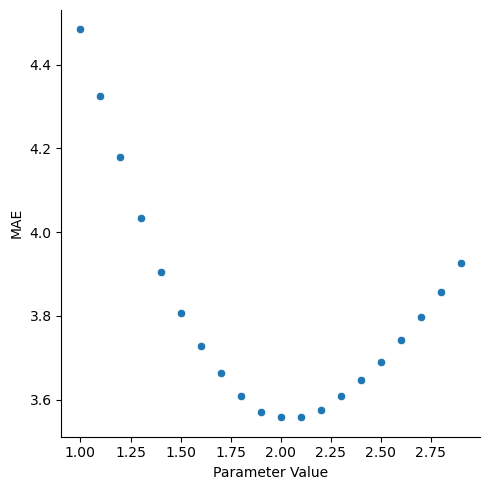

In [13]:
# Note, this is a laborious way to do this; it is intended as an illustration.
# In practice, we'll use automated methods to fit models (mostly in the sklearn
# library).

def prediction_error(m):
    """ Return the prediction error associated with the value
    of the parameter. Note that this model uses only a single
    parameter - the intercept C is fixed by the choice of M.
    """
    who_with_predictions = (
        who_data_2015[["Schooling", "Life expectancy"]]
        # Add a column for our predictions.
        .assign(Predicted=lambda df: df["Schooling"] * m + 73 - 13 * m)
        .dropna()
    )
    errors = who_with_predictions['Life expectancy'] - who_with_predictions['Predicted']
    return errors.abs().mean()

# Create a dataframe with a column for test values of the parameter m
# and another column for the associated MAE of the prediction.
test_parameter_values = np.arange(1, 3, 0.1)  # Values spread across the interval 1 -> 3, separated by 0.1
cost_function_results = pd.DataFrame({
    "Parameter Value": test_parameter_values,
    # Use a Python list comprehension to find MAE for each proposed parameter value.
    "MAE": [prediction_error(m) for m in test_parameter_values],
})
sns.relplot(
    data=cost_function_results,
    x="Parameter Value",
    y="MAE"
);

This is an illustration of the **cost function** of this model: how the error measure varies with the parameter value choice. We can see that the lowest MAE is at around about a parameter value of $2.0$. Selecting this parameter value gives our **fitted model**. You'll see that this model has a slightly lower error (below $3.6$, where previously we saw $3.9$) than the choice we made earlier. The predictions made by this model are shown below.

,Schooling,Life expectancy,Predicted
0,10.1,65.0,67.2
16,14.2,77.8,75.4
32,14.4,75.6,75.8
48,11.4,52.4,69.8
64,13.9,76.4,74.8


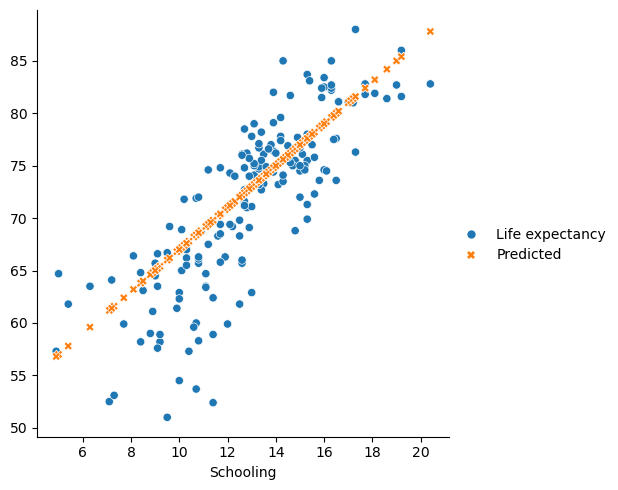

In [14]:
m = 2.0
who_with_predictions = (
    who_data_2015[["Schooling", "Life expectancy"]]
    .assign(Predicted=lambda df: df["Schooling"] * m + 73 - 13 * m)
    .dropna()
)
sns.relplot(data=who_with_predictions.set_index("Schooling"));
who_with_predictions.head()

## Testing and Training

The above examples outline the process of **training** a supervised machine learning model: fitting it to known data by choosing its parameters so that error is minimised. In practice, we need to split our data into training and testing sets before conducting the training process. The cost function for fitting the model is based on the training data, but we use the test data to assess how the fitted model performs and compute our final estimates of model error.

## Exercises

Complete these before the studio in week 3, and submit the completed notebook through Moodle.

### Exercise 1

Given the dataframe `ex1_who_with_predictions` below, compute the Mean Absolute Error for the predicted values of life expectancy. You can repeat the process previously shown, or find a function in `sklearn.metrics` to compute this for you.

In [16]:
ex1_who_with_predictions = (
    who_data_2015[["Schooling", "Life expectancy"]]
    .assign(Predicted=lambda df: df["Schooling"] * 2.3 + 43)
    .dropna()
)
ex1_who_with_predictions.head()

,Schooling,Life expectancy,Predicted
0,10.1,65.0,66.23
16,14.2,77.8,75.66
32,14.4,75.6,76.12
48,11.4,52.4,69.22
64,13.9,76.4,74.97


In [17]:
# Compute mean absolute error.
errors=ex1_who_with_predictions['Predicted']-ex1_who_with_predictions['Life expectancy']
mae_score = errors.abs().mean()
print(f"Mean absolute error is {mae_score:.1f} years")

Mean absolute error is 3.6 years


### Exercise 2

Given the classification predictions and actual results in the dataframe `ex2_biopsies_with_predictions` below, compute accuracy, precision and recall. Also find the number of false negatives.

In [19]:
ex2_biopsies_with_predictions = (
    wisconsin_cancer_biopsies
    .assign(prediction=lambda df: df['texture_mean'].lt(20)
        .map({True: "benign", False: "malignant"})
    )
    [['radius_mean', 'texture_mean', 'diagnosis', 'prediction']]
)
ex2_biopsies_with_predictions.head()

,radius_mean,texture_mean,diagnosis,prediction
0,17.99,10.38,malignant,benign
1,20.57,17.77,malignant,benign
2,19.69,21.25,malignant,malignant
3,11.42,20.38,malignant,malignant
4,20.29,14.34,malignant,benign


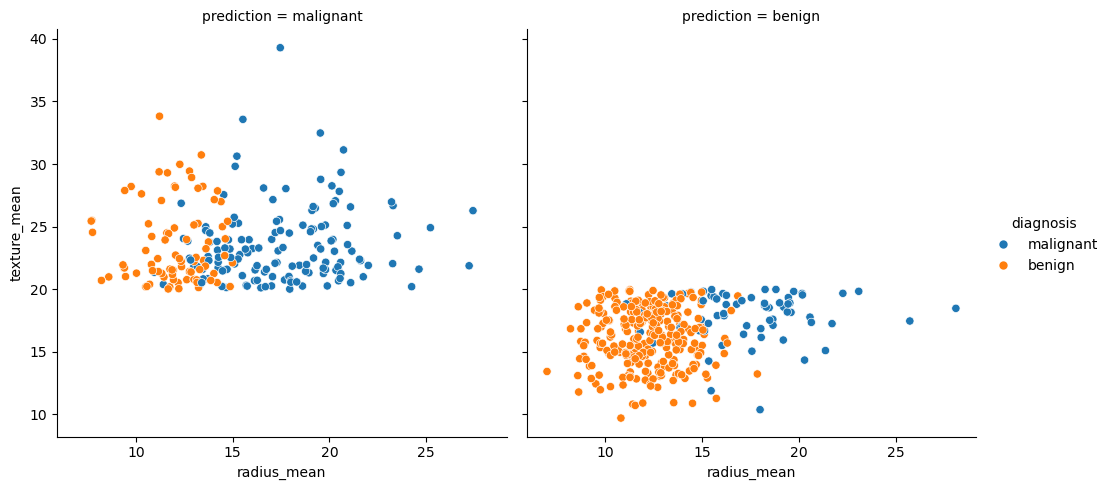

In [20]:
sns.relplot(
    data=ex2_biopsies_with_predictions,
    x="radius_mean",
    y="texture_mean",
    hue="diagnosis",
    hue_order=["malignant", "benign"],
    col="prediction",
    col_order=["malignant", "benign"],
);

In [21]:
ex2_biopsies_with_predictions.groupby(['diagnosis','prediction']).count().unstack()

radius_mean           texture_mean          
prediction      benign malignant       benign malignant
diagnosis                                              
benign             274        83          274        83
malignant           70       142           70       142

In [22]:
recall=precision_score(y_true=ex2_biopsies_with_predictions['diagnosis'],
                y_pred=ex2_biopsies_with_predictions['prediction'],
                pos_label='benign')
print(f"precision score is: {recall}")


precision score is: 0.7965116279069767


In [23]:
TP = 274   # True positives
TN = 142  # True negatives
FP = 83   # False positives
FN = 70   # False negatives
TOTAL = TP + TN + FP + FN

print(f"Accuracy = {(TP + TN) / TOTAL = :.3f}")
print(f"Precision = {TP / (TP + FP) = :.3f}")
print(f"Recall = {TP / (TP + FN) }")

Accuracy = (TP + TN) / TOTAL = 0.731
Precision = TP / (TP + FP) = 0.768
Recall = 0.7965116279069767


### Exercise 3

Consider three different predictors for the cancer biopsy screening dataset:

* Predictor A has an accuracy of 0.95, and recall of 0.99
* Predictor B has an accuracy of 0.99, and recall of 0.95
* Predictor C has an accuracy of 0.5, and a recall of 1.0

The test required to collect data from a new patient (on which the predictor will give a predicted diagnosis) is minimally invasive. If the predictor predicts a positive (malignant) diagnosis, the patient will be referred for further screening which can be expensive.

Considering the context, which predictive model (A, B, or C) would likely be preferred for this task? Write your answer in a markdown cell below, and give a brief explanation of your reasoning.

it has a perfect recall(?)

### Exercise 4

The function `model_correct_predictions` below returns the number of correct predictions made by a predictive model for the cancer biopsy dataset, for a given parameter value. This parameter value simply controls the threshold value for radius above which a sample is predicted as malignant.

Try different values of the parameter in this model within the range [0, 30]. Record and plot the resulting accuracy values against the parameter value (similar to the regression cost function example above).

What value of the parameter provides the best error rate? Explain how can you be confident you have found the best result here.

In [24]:
def model_correct_predictions(radius_split_parameter):
    """ Return the number of correct predictions made by the model
    for the given parameter value. """
    data = wisconsin_cancer_biopsies.assign(
        predicted=lambda df: df['radius_mean'].lt(radius_split_parameter)
            .map({True: "benign", False: "malignant"})
    )
    return (data['diagnosis'] == data['predicted']).sum()

model_correct_predictions(12)

369

(15, 0.8875219683655536)

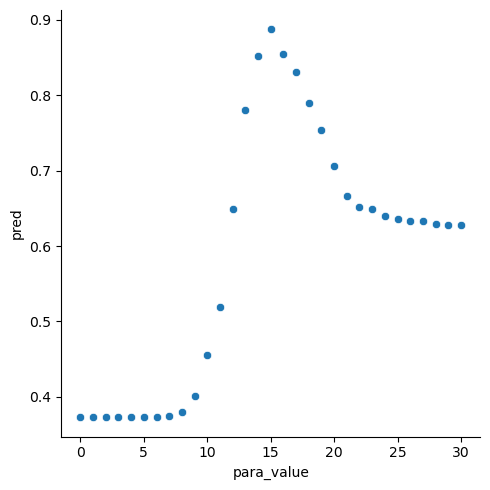

In [25]:

para_value=np.arange(0,31,1)
total_samples=len(wisconsin_cancer_biopsies)


results=pd.DataFrame({
    "para_value":para_value,
    "pred": [model_correct_predictions(p)/total_samples for p in para_value]
})
sns.relplot(
    data=results,
    x="para_value",
    y="pred"
);

best_para=para_value[np.argmax(results["pred"])]
highest_accuracy = max(results["pred"])

best_para,highest_accuracy

In [ ]:
m = 2.0
who_with_predictions = (
    who_data_2015[["Schooling", "Life expectancy"]]
    .assign(Predicted=lambda df: df["Schooling"] * m + 73 - 13 * m)
    .dropna()
)
sns.relplot(data=who_with_predictions.set_index("Schooling"));
who_with_predictions.head()

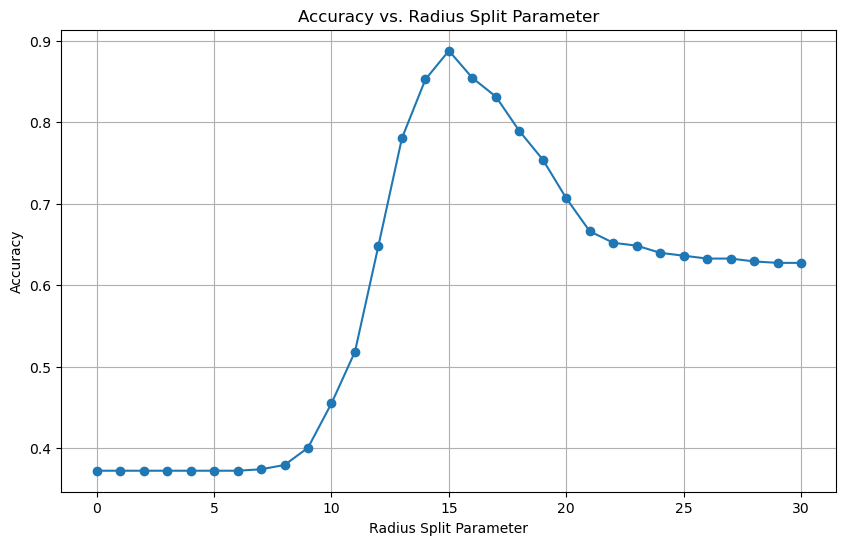

(15, 0.8875219683655536)

In [159]:
radius_split_parameters = np.arange(0, 31, 1)

# Calculate accuracy for each parameter value
accuracies = [model_correct_predictions(p) / len(wisconsin_cancer_biopsies) for p in radius_split_parameters]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(radius_split_parameters, accuracies, marker='o')
plt.xlabel('Radius Split Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Radius Split Parameter')
plt.grid(True)
plt.show()


# Find the parameter value with the highest accuracy
best_parameter = radius_split_parameters[np.argmax(accuracies)]
best_accuracy = max(accuracies)

best_parameter, best_accuracy